In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv


In [2]:
# Parameters
alpha = 0.5  # Thermal diffusivity
length = 1.0  # Length of the rod
time_end = 1  # End time
num_points = 30  # Number of spatial points
num_steps = 1000  # Number of time steps

In [3]:
# Spatial and time step sizes
dx = length / (num_points - 1)
dt = time_end / num_steps

In [4]:
# Initial condition
initial_temperature = np.zeros(num_points)

In [5]:
# Set one end at 25 degrees and the other end at 600 degrees
initial_temperature[0] = 100.0  # Set the first element (one end) to 25 degrees
initial_temperature[-1] = 600.0  # Set the last element (other end) to 600 degrees


In [6]:
# Initialize temperature array
temperature = initial_temperature.copy()

In [7]:
# Store temperature at each time step
time_steps = np.linspace(0, time_end, num_steps + 1)
temperature_history = [temperature.copy()]


In [8]:
# Finite difference method
for n in range(1, num_steps + 1):
    # Compute new temperature values using finite difference
    temperature[1:-1] = (
        temperature[1:-1]
        + alpha * dt / dx**2 * (temperature[2:] - 2 * temperature[1:-1] + temperature[:-2])
    )
    # Store the temperature at this time step
    temperature_history.append(temperature.copy())


<Figure size 720x432 with 0 Axes>

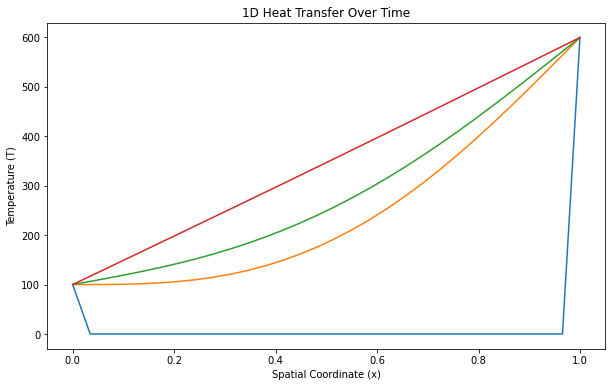

In [29]:
# Plot the results
plt.figure(figsize=(10, 6))
# Plot spatial variation at different time steps

time_steps_to_plot = [0, 0.2, 0.3,1]  # Add the specific time steps you want to plot

plt.figure(figsize=(10, 6))

# Plot spatial variation at specific time steps
for time_step in time_steps_to_plot:
    # Find the index corresponding to the time_step
    index_to_plot = np.where(np.array(time_steps) == time_step)[0][0]
    
    # Plot the selected time step
    plt.plot(np.linspace(0, length, num_points), temperature_history[index_to_plot],
             label=f'Time = {time_step:.2f}')



plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Temperature (T)')
plt.title('1D Heat Transfer Over Time')
#plt.legend()
plt.show()

In [10]:
# Save data to CSV file
csv_filename = 'heat_transfer_data_with_time.csv'

with open(csv_filename, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Spatial Coordinate (x)', *time_steps])
    csv_writer.writerows(np.column_stack((np.linspace(0, length, num_points), *temperature_history)))

print(f'Data saved to {csv_filename}')

Data saved to heat_transfer_data_with_time.csv


ML training Section
Here a neural network of the HT temperature data is developed.

In [11]:
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Data preparation

Extract the features and the target data

In [12]:
raw_data =  pd.read_csv('heat_transfer_data_with_time.csv')
#print(raw_data.head)

X1 = raw_data['Spatial Coordinate (x)'].values
print(len(X1))
X2 = np.arange(0,time_end +dt,dt)
print(len(X2))
#y = np.zeros(len(X1)*len(X2))
#print(len(y))

y_data = raw_data.iloc[0:,1:].values.ravel()
#y = y_data.flatten()
print(y_data)


ftr = list(itertools.product(X1,X2))
feature = np.array(ftr)



30
1001
[100. 100. 100. ... 600. 600. 600.]


Training of SVR

In [28]:
svr_rbf = svm.SVR(kernel="rbf", C=200, gamma=150, epsilon=0.8)

svr_rbf.fit(feature, y_data)




SVR(C=200, epsilon=0.8, gamma=150)

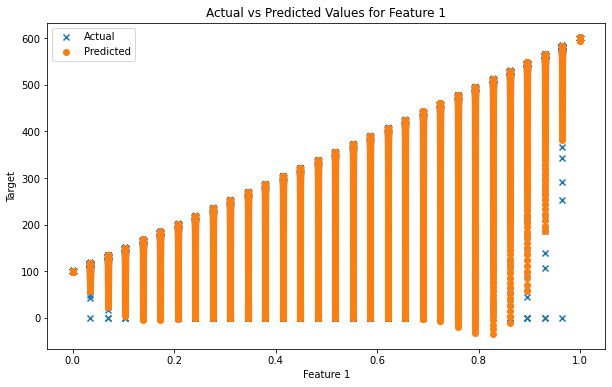

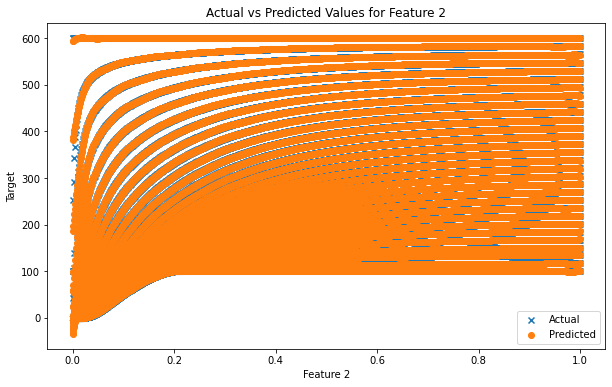

In [27]:
import matplotlib.pyplot as plt

# Assuming you have y_data, y_pred, and feature

# Scatter plot for Feature 1
plt.figure(figsize=(10, 6))
plt.scatter(feature[:, 0], y_data, label='Actual', marker='x')
plt.scatter(feature[:, 0], y_pred, label='Predicted', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.title('Actual vs Predicted Values for Feature 1')
plt.legend()
plt.show()

# Scatter plot for Feature 2
plt.figure(figsize=(10, 6))
plt.scatter(feature[:, 1], y_data, label='Actual', marker='x')
plt.scatter(feature[:, 1], y_pred, label='Predicted', marker='o')
plt.xlabel('Feature 2')
plt.ylabel('Target')
plt.title('Actual vs Predicted Values for Feature 2')
plt.legend()
plt.show()



SVR modelling